In [83]:
import cv2         
import numpy as np   
import matplotlib.pyplot as plt

In [84]:
def turnGrayscale(image_path):    
    img = cv2.imread(image_path)
    img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    plt.imshow(img_gray , cmap='gray')
    plt.title('Gray scale')
    plt.show()
    return img_gray

In [85]:
def medianFilter(image):
    img_blur = cv2.blur(image, (1, 17))
    img_filtered = cv2.medianBlur(img_blur, 5)

    if len(img_filtered.shape) == 3:
        img_filtered = cv2.cvtColor(img_filtered, cv2.COLOR_BGR2GRAY)

    img_filtered = np.uint8(np.clip(img_filtered, 0, 255))

    _, img_thresh = cv2.threshold(img_filtered, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    plt.imshow(img_thresh, cmap='gray')
    plt.title('Median')
    plt.show()

    return img_thresh

In [86]:
def histogramStretching(image):
    min = np.min(image)
    max = np.max(image)
    image = np.uint8((image - min) / (max - min) * 255)
    return image

In [87]:
def rotateBarcode(image):

    edges = cv2.Canny(image, 50, 150)

    contours, _ = cv2.findContours(edges, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    if contours:
        largest_contour = max(contours, key=cv2.contourArea)

        rect = cv2.minAreaRect(largest_contour)
        box = cv2.boxPoints(rect)
        box = np.int32(box)

        angle = rect[-1]
        if angle < -45:
            angle -= 90

        (h, w) = image.shape[:2]
        center = (w // 2, h // 2)
        rotation_matrix = cv2.getRotationMatrix2D(center, angle, 1.0)
        img_rotated = cv2.warpAffine(image, rotation_matrix, (w, h), flags=cv2.INTER_LINEAR, borderMode=cv2.BORDER_CONSTANT, borderValue=(255, 255, 255))

        box = np.int32(cv2.transform(np.array([box]), rotation_matrix)[0])
        x, y, h, w = cv2.boundingRect(box)

        if h > w:
            img_rotated = cv2.rotate(img_rotated, cv2.ROTATE_90_CLOCKWISE)
    
    plt.imshow(img_rotated , cmap='gray')
    plt.title('Rotate')
    plt.show()

    return img_rotated

In [ ]:
def closeOpen(image):

    kernel_height = image.shape[0] //5
    kernel_width = image.shape[1] // 100 

    print (kernel_height , kernel_width)
    kernel = np.ones((kernel_height, kernel_width), np.uint8)

    img_closed = cv2.morphologyEx(image, cv2.MORPH_CLOSE, kernel, iterations=1)

    img_opened = cv2.morphologyEx(img_closed, cv2.MORPH_OPEN, kernel, iterations=1)

    plt.imshow(img_opened, cmap='gray')
    plt.title('Opened Image')
    plt.show()

    return img_opened

In [89]:
def extractBarcode(image):
    img_thresh_inv = cv2.bitwise_not(image)

    x, y, w, h = cv2.boundingRect(img_thresh_inv)

    barcode = image[y:y+h-h//4, x:x+w]
    
    plt.imshow(barcode, cmap='gray')
    plt.title('extract')
    plt.show()
    return barcode


In [ ]:

def removeFrequency(image):
    # Step 1: Convert image to the frequency domain
    f = np.fft.fft2(image)
    fshift = np.fft.fftshift(f)  # Shift zero frequency to the center
    magnitude_spectrum = 20 * np.log(np.abs(fshift) + 1)

    # Step 2: Remove the high-frequency components or apply averaging
    rows, cols = image.shape
    crow, ccol = rows // 2, cols // 2  # Center point
    
    # Define a radius for the mask to affect low frequencies
    radius = 30  # Adjust based on the frequency spread
    mask = np.ones((rows, cols), np.uint8)
    
    y, x = np.ogrid[:rows, :cols]
    mask_area = (x - ccol) ** 2 + (y - crow) ** 2 <= radius ** 2
    mask[mask_area] = 0  
    
    # Extract the region inside the mask (low-frequency region)
    low_freq_area = fshift * (1 - mask)  # Area to average
    non_zero_mask = (1 - mask).astype(bool)
    
    # Calculate the average of the low-frequency region
    avg_value = np.mean(low_freq_area[non_zero_mask])  # Calculate average of the low-frequency values
    
    # Replace the low-frequency region with the average value
    fshift[mask_area] = avg_value
    
    # Step 3: Convert back to the spatial domain
    f_ishift = np.fft.ifftshift(fshift)
    img_filtered = np.abs(np.fft.ifft2(f_ishift))

    # Normalize the image to 0-255 range
    img_filtered = cv2.normalize(img_filtered, None, 0, 255, cv2.NORM_MINMAX)
    img_filtered = np.uint8(img_filtered)
    inverted_image = cv2.bitwise_not(img_filtered)

    # Display the filtered image
    plt.imshow(inverted_image, cmap='gray')
    plt.title('Filtered Image with Averaging')
    plt.show()

    return inverted_image


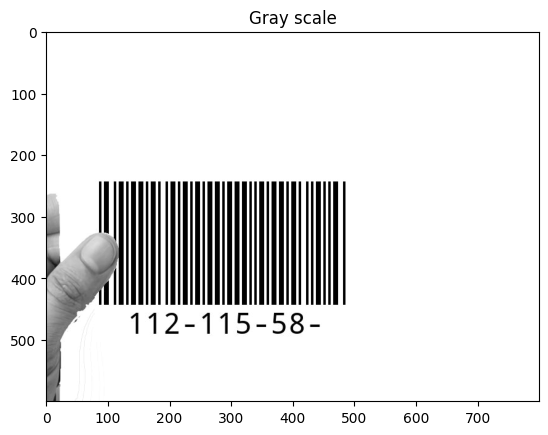

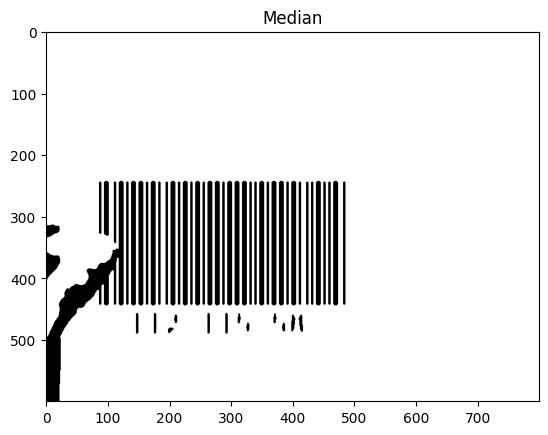

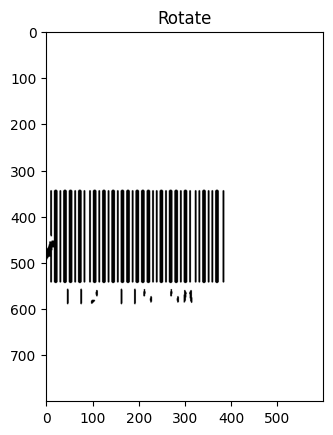

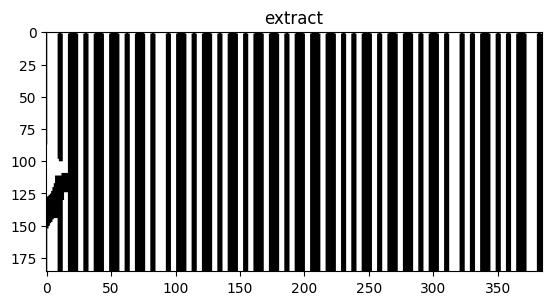

186 3


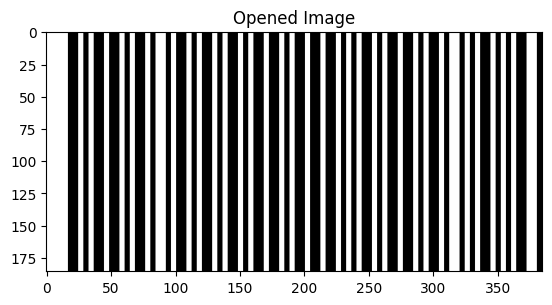

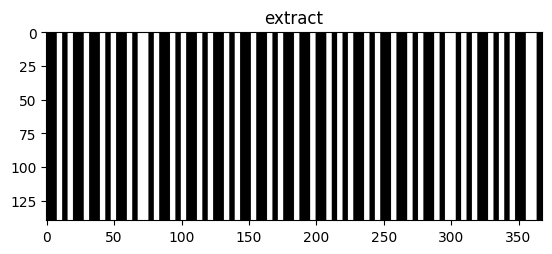

In [91]:
# Logic not complete and not tested for all 
# cases but this is the general idea

image = turnGrayscale('Test Cases/03 - eda ya3am ew3a soba3ak mathazarsh.jpg')
#image = removeFrequency(image)
image=histogramStretching(image)

image = medianFilter(image)

image = rotateBarcode(image)

image = extractBarcode(image)

image = closeOpen(image)

image = extractBarcode(image)

